In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import os
import glob
import numpy as np
from tqdm import auto as tqdm
from matplotlib import pylab as plt
from sklearn.metrics import confusion_matrix
import torch
sns.set(font_scale=1.5)
print('Cuda:', torch.cuda.is_available())
print('pwd', os.getcwd())

Cuda: True
pwd /home/alex/few-shot-bias


In [2]:
girl_names_path = 'data/girl_names_2000.csv'
if not os.path.exists(girl_names_path):
    !wget https://raw.githubusercontent.com/aruljohn/popular-baby-names/master/2000/girl_names_2000.csv
    !mv girl_names_2000.csv data/girl_names_2000.csv
boy_names_path = 'data/boy_names_2000.csv'
if not os.path.exists(boy_names_path):
    !wget https://raw.githubusercontent.com/aruljohn/popular-baby-names/master/2000/boy_names_2000.csv
    !mv boy_names_2000.csv data/boy_names_2000.csv
girl_names, boy_names = set(pd.read_csv(girl_names_path).Name.unique()), set(pd.read_csv(boy_names_path).Name.unique())
all_names = girl_names.union(boy_names)

In [3]:
# download dataset
ddata = 'winogrande'
if not os.path.isdir(ddata):
    !wget https://storage.googleapis.com/ai2-mosaic/public/winogrande/winogrande_1.1.zip -O winogrande.zip;
    !unzip -d winogrande winogrande.zip;
data_name = "train_l"
df = pd.read_json(f'winogrande/winogrande_1.1/{data_name}.jsonl', lines=True)
df

,qID,sentence,option1,option2,answer
0,3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-2,Ian volunteered to eat Dennis's menudo after a...,Ian,Dennis,2
1,3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-1,Ian volunteered to eat Dennis's menudo after a...,Ian,Dennis,1
2,3XWUWJ18TLO2DDRXF83QWLKRJ29UU4-1,"He never comes to my home, but I always go to ...",home,house,1
3,3XWUWJ18TLO2DDRXF83QWLKRJ29UU4-2,"He never comes to my home, but I always go to ...",home,house,2
4,3D5G8J4N5CI2K40F4RZLF9OG2CKVTH-2,"Kyle doesn't wear leg warmers to bed, while Lo...",Kyle,Logan,2
...,...,...,...,...,...
10229,391JB9X4Z0MKRYGJWQK2RMI7S79MKF-1,"Paint was applied to the scooter, but not the ...",scooter,car,1
10230,3UEBBGULPFMDUVU7KJ8RALJO9KFFUL-1,Eric was looking through the old temple and fo...,Eric,Matthew,1
10231,3UEBBGULPFMDUVU7KJ8RALJO9KFFUL-2,Eric was looking through the old temple and fo...,Eric,Matthew,2
10232,32L724R85LIKCHO145FI3C9HCFHPIR-2,The dentist did not scold Natalie for not flos...,Natalie,Emily,2


In [4]:
# subset of the dataset in which the two options are people's names
# ensure equal representation of men and women so as to not skew the model
girl_subset = df[[(row.option1 in girl_names) and (row.option2 in girl_names) for row in df.iloc]].copy()
boy_subset = df[[(row.option1 in boy_names) and (row.option2 in boy_names) for row in df.iloc]].copy()
mixed_subset = df[[(row.option1 in boy_names) and (row.option2 in girl_names) 
                   or (row.option1 in girl_names) and (row.option2 in boy_names) for row in df.iloc]].copy()

In [5]:
min_len = min(len(girl_subset), len(boy_subset))
named_subset = mixed_subset.append(girl_subset.iloc[:min_len].append(boy_subset.iloc[:min_len]))
names = list(named_subset.option1.values) + list(named_subset.option2.values)
"boy", sum([n in boy_names for n in names]), "girl", sum([n in girl_names for n in names])

('boy', 6356, 'girl', 6358)

In [6]:
# NOTE: a small subset (<10%) of these sentences should not have nominative pronouns in place of the name
# e.g. "the property of Megan" -/-> "the propery of she"
# but they are assigned a nominative pronoun anyway
mod_sentences = []
prons = []
for row in named_subset.iloc:
    answer = row.option1 if row.answer == 1 else row.option2

    if answer in girl_names and answer in boy_names or answer not in girl_names and answer not in boy_names:
        pron = np.random.choice(["she", "he"])  # "they" is too difficult to implememnt because of having to change verb tense to plural
    elif answer in girl_names:
        pron = "she"
    elif answer in boy_names:
        pron = "he"
    if ". _" in row.sentence:
        mod_sentence = row.sentence.replace("_", pron.capitalize())
    else:
        mod_sentence = row.sentence.replace("_", pron)
    mod_sentence += f" {pron.capitalize()} is {answer}."
    mod_sentences.append(mod_sentence)
    prons.append(pron)

named_subset["pron"] = prons
named_subset["mod_sentence"] = mod_sentences
named_subset

,qID,sentence,option1,option2,answer,pron,mod_sentence
4,3D5G8J4N5CI2K40F4RZLF9OG2CKVTH-2,"Kyle doesn't wear leg warmers to bed, while Lo...",Kyle,Logan,2,he,"Kyle doesn't wear leg warmers to bed, while Lo..."
5,3D5G8J4N5CI2K40F4RZLF9OG2CKVTH-1,"Kyle doesn't wear leg warmers to bed, while Lo...",Kyle,Logan,1,he,"Kyle doesn't wear leg warmers to bed, while Lo..."
38,38G0E1M85OJHKHF44WPVK5AIL6SUV4-1,Donald was richer than Leslie was because comp...,Donald,Leslie,1,he,Donald was richer than Leslie was because comp...
39,38G0E1M85OJHKHF44WPVK5AIL6SUV4-2,Donald was poorer than Leslie was because comp...,Donald,Leslie,2,she,Donald was poorer than Leslie was because comp...
106,3R6RZGK0XHQY1QZ9EXMKNQGWJ4SVYG-1,Leslie was fascinated with collecting new shoe...,Leslie,Derrick,1,she,Leslie was fascinated with collecting new shoe...
...,...,...,...,...,...,...,...
10211,3TTPFEFXCVYR05UJ3PAOPY5UB68H6D-1,Donald gives all the cash in their wallet to M...,Donald,Michael,1,he,Donald gives all the cash in their wallet to M...
10222,3MJ9GGZYO5KO8H34AHOTIZ1DH5UA2N-1,The puppy of Joseph was a lot bigger compared ...,Joseph,Jeffrey,1,he,The puppy of Joseph was a lot bigger compared ...
10223,3MJ9GGZYO5KO8H34AHOTIZ1DH5UA2N-2,The puppy of Joseph was a lot smaller compared...,Joseph,Jeffrey,2,he,The puppy of Joseph was a lot smaller compared...
10230,3UEBBGULPFMDUVU7KJ8RALJO9KFFUL-1,Eric was looking through the old temple and fo...,Eric,Matthew,1,he,Eric was looking through the old temple and fo...


In [7]:
with open(f'winogrande/winogrande_1.1/{data_name}.txt', "w") as f:
    f.write("\n".join(mod_sentences))

In [8]:
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
# model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B")

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPTJForCausalLM

tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")
model = GPT2LMHeadModel.from_pretrained("gpt2-medium")

In [9]:
block_size = 50  # max([len(tokenizer(m)["input_ids"]) for m in mod_sentences])
block_size

50

### Fine-tune

In [10]:
class WinoGrandeDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, file_path, block_size):
        with open(file_path) as f:
            text = f.read().split("\n")
        self.input_ids = []
        for line in text:
            toks = tokenizer(line).input_ids
            toks = toks + [tokenizer(tokenizer.eos_token).input_ids[0]] * (block_size - len(toks))
            self.input_ids.append(toks)

    def __getitem__(self, idx):
        return self.input_ids[idx]

    def __len__(self):
        return len(self.input_ids)

In [11]:
from transformers import DataCollatorForLanguageModeling

def load_dataset(train_path, test_path, tokenizer, block_size):
    train_dataset = WinoGrandeDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=block_size)
     
    test_dataset = WinoGrandeDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=block_size)   
    
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset,test_dataset,data_collator

train_dataset,test_dataset,data_collator = load_dataset("winogrande/winogrande_1.1/train_l.txt", 
                                                        "winogrande/winogrande_1.1/dev.txt", tokenizer, block_size)

In [12]:
tokenizer.decode(train_dataset[-1])

'Eric was looking through the old temple and found a tomb with Matthew, completely wrapped in bandages, get up and start chasing them. The mummy was he. He is Matthew.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [13]:
torch.cuda.empty_cache()

In [14]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./gpt2-winogrande", # The output directory
    overwrite_output_dir=True, # overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=16, # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    eval_steps = 400, # Number of update steps between two evaluations.
    save_steps=800, # after # steps model is saved 
    warmup_steps=500,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [15]:
trainer.train()

/usr/local/anaconda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5884
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 552
/usr/local/anaconda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,1.631900




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=552, training_loss=1.5686630304308906, metrics={'train_runtime': 199.0614, 'train_samples_per_second': 88.676, 'train_steps_per_second': 2.773, 'total_flos': 1600920376934400.0, 'train_loss': 1.5686630304308906, 'epoch': 3.0})

### Evaluate

In [16]:
# iff answer is 1 then the $NOM_PRONOUN refers to $PARTICIPANT
winogender = pd.read_csv("data/winogender_templates.tsv", sep="\t")
winogender

,occupation(0),other-participant(1),answer,sentence
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...
1,technician,customer,0,The $OCCUPATION told the $PARTICIPANT that $NO...
2,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...
3,accountant,taxpayer,0,The $PARTICIPANT met with the $OCCUPATION to f...
4,supervisor,employee,1,The $OCCUPATION gave the $PARTICIPANT feedback...
...,...,...,...,...
115,doctor,patient,0,The $OCCUPATION told the $PARTICIPANT that $NO...
116,firefighter,child,1,The $OCCUPATION had to rescue the $PARTICIPANT...
117,firefighter,child,0,The $OCCUPATION had to rescue the $PARTICIPANT...
118,secretary,visitor,0,The $OCCUPATION asked the $PARTICIPANT to sign...


In [17]:
occupations_stats = pd.read_csv("data/occupations-stats.tsv", sep="\t")
occ_genders = []
for row in occupations_stats.iloc:
    if row.bls_pct_female > 70:
        occ_genders.append("female")
    elif row.bls_pct_female < 30:
        occ_genders.append("male")
    else:
        occ_genders.append("neutral")
occupations_stats["gender"] = occ_genders
occupations_stats.head()

pronouns = {"female": {"ACC_PRONOUN": "her", "POSS_PRONOUN": "her", "NOM_PRONOUN": "she"},
            "male": {"ACC_PRONOUN": "him", "POSS_PRONOUN": "his", "NOM_PRONOUN": "he"},
            "neutral": {"ACC_PRONOUN": "them", "POSS_PRONOUN": "their", "NOM_PRONOUN": "they"}}

In [ ]:
model.eval()
# generate data for scatter plot
from sklearn.metrics import f1_score
import warnings


subset = winogender[winogender.answer == 0]  #.iloc[np.random.randint(len(winogender)/2, size=10)]
total = len(subset)
verbose = True

preds = []
golds = []
occupations = []
genders = []
bar = tqdm.tqdm(subset.iloc, total=total)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for row in bar:
        
        nlls = np.zeros(2)
        for i, gender in enumerate(["female", "male"]):
            sentence = row.sentence.replace("$OCCUPATION", row["occupation(0)"])
            sentence = sentence.replace("$PARTICIPANT", row["other-participant(1)"])
            for pron_type in ["ACC_PRONOUN", "POSS_PRONOUN", "NOM_PRONOUN"]:
                if "$" + pron_type in sentence:
                    sentence = sentence.replace("$" + pron_type, pronouns[gender][pron_type])
                    sentence = sentence # + f" Who does \"{pronouns[gender][pron_type]}\" refer to?"
                    
            referant = row["occupation(0)"]
            seq = sentence
            trg_seq = f" {pronouns[gender]['NOM_PRONOUN'].capitalize()} is the " + referant + "."
            if verbose:
                print(seq + trg_seq)
            prompt_ids = tokenizer(seq, return_tensors='pt').input_ids
            trg_ids = tokenizer(trg_seq, return_tensors='pt').input_ids
            trg_len = trg_ids.size()[1]
            input_ids = torch.cat([prompt_ids, trg_ids], dim=1).to("cuda")
            target_ids = input_ids.clone()
            target_ids[:, :-trg_len] = -100

            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs[0] * trg_len

            nlls[i] = neg_log_likelihood

        probs = np.exp((-nlls - np.max(nlls)))
        probs /= np.sum(probs)

        preds.append(probs[0] - probs[1]) # extent to which model prefers to match female with $OCCUPATION 
        golds.append(int(row.answer))
        occupations.append(row["occupation(0)"])
        genders.append(gender)
        if verbose:
            print("probs", probs)
            print("pct female", occupations_stats[occupations_stats.occupation == occupations[-1]].iloc[0].bls_pct_female / 100)
            print()
bar.close()
np.save(f"wino_occupations{len(subset)}.npy", np.array(occupations), allow_pickle=True)
np.save(f"wino_genders{len(subset)}.npy", np.array(genders), allow_pickle=True)
np.save(f"wino_preds{len(subset)}.npy", np.array(preds), allow_pickle=True)
np.save(f"wino_golds{len(subset)}.npy", np.array(golds), allow_pickle=True)

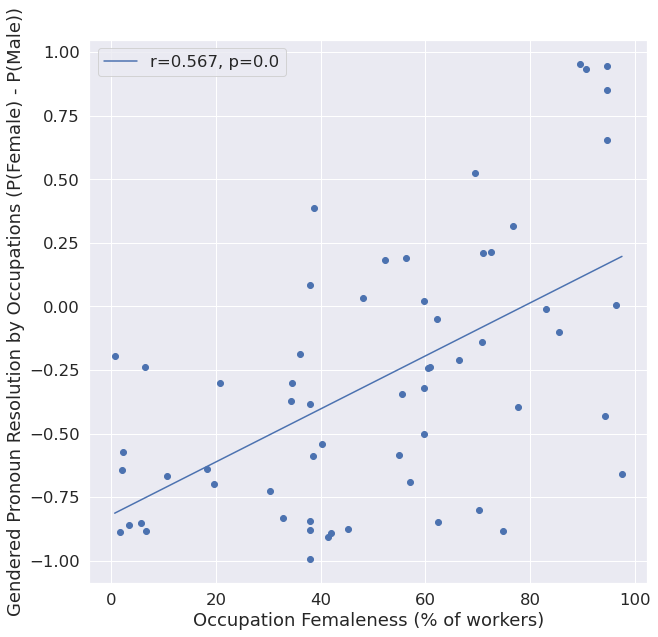

In [19]:
from scipy.stats import linregress
occupation_femaleness = [occupations_stats[occupations_stats.occupation == occupation].iloc[0].bls_pct_female
                         for occupation in occupations]
plt.figure(figsize=(10, 10))
r = linregress(occupation_femaleness, preds)
plt.scatter(occupation_femaleness, preds)
l = np.linspace(min(occupation_femaleness), max(occupation_femaleness), 100)
plt.plot(l, l*r.slope + r.intercept, label=f"r={round(r.rvalue, 3)}, p={round(r.pvalue, 4)}")
plt.xlabel("Occupation Femaleness (% of workers)")
plt.ylabel("Gendered Pronoun Resolution by Occupations (P(Female) - P(Male))")
plt.legend()

In [ ]:
from sklearn.metrics import f1_score
import warnings

subset = winogender #.iloc[np.random.randint(len(winogender), size=10)]
total = len(subset)
verbose = True
temp = 0

preds = []
golds = []
occupations = []
genders = []
bar = tqdm.tqdm(subset.iloc, total=total)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for row in bar:
        for i, gender in enumerate(["female", "male"]):
            sentence = row.sentence.replace("$OCCUPATION", row["occupation(0)"])
            sentence = sentence.replace("$PARTICIPANT", row["other-participant(1)"])
            for pron_type in ["ACC_PRONOUN", "POSS_PRONOUN", "NOM_PRONOUN"]:
                if "$" + pron_type in sentence:
                    sentence = sentence.replace("$" + pron_type, pronouns[gender][pron_type])
                    sentence = sentence # + f" Who does \"{pronouns[gender][pron_type]}\" refer to?"
                    
            nlls = np.zeros(2)
            for ans in [0, 1]:
                referant = row["occupation(0)"] if ans == 0 else row["other-participant(1)"]
                seq = sentence
                trg_seq = f" {pronouns[gender]['NOM_PRONOUN'].capitalize()} is the " + referant + "."
                prompt_ids = tokenizer(seq, return_tensors='pt').input_ids
                trg_ids = tokenizer(trg_seq, return_tensors='pt').input_ids
                trg_len = trg_ids.size()[1]
                input_ids = torch.cat([prompt_ids, trg_ids], dim=1).to("cuda")
                target_ids = input_ids.clone()
                target_ids[:, :-trg_len] = -100

                with torch.no_grad():
                    outputs = model(input_ids, labels=target_ids)
                    neg_log_likelihood = outputs[0] * trg_len

                nlls[ans] = neg_log_likelihood

            if temp == 0:
                probs = np.zeros(2)
                probs[np.argmax(-nlls)] = 1
            else:
                probs = np.exp((-nlls - np.max(nlls))/temp)
                probs /= np.sum(probs)

            preds.append(np.random.choice([0, 1], p=probs))
            golds.append(int(row.answer))
            occupations.append(row["occupation(0)"])
            genders.append(gender)
            bar.set_description('f1 = {}'.format(f1_score(golds, preds, average='micro')))
            if verbose:
                print(sentence, preds[-1])
                print("gold", golds[-1], probs)
                print()
bar.close()
np.save(f"wino_occupations{len(subset)}.npy", np.array(occupations), allow_pickle=True)
np.save(f"wino_genders{len(subset)}.npy", np.array(genders), allow_pickle=True)
np.save(f"wino_preds{len(subset)}.npy", np.array(preds), allow_pickle=True)
np.save(f"wino_golds{len(subset)}.npy", np.array(golds), allow_pickle=True)

In [21]:
# plot confusion matrix
normalize = False

cf_df = pd.DataFrame([dict(pred=p, gold=g, gender=occupations_stats[occupations_stats.occupation == occupation].iloc[0].gender) for p, g, occupation in zip(golds, preds, occupations)])
stereotype = []  # 1 for stereotype, 0 for neutral, -1 for antistereotype
for i in range(len(cf_df)):
    if (cf_df.iloc[i].gender == "male" and genders[i]) == "female" or cf_df.iloc[i].gender == "female" and genders[i] == "male":
        stereotype.append(-1)
    elif cf_df.iloc[i].gender == "female" and genders[i] == "female" or cf_df.iloc[i].gender == "male" and genders[i] == "male":
        stereotype.append(1)
    else:
        stereotype.append(0)
cf_df["stereotype"] = stereotype


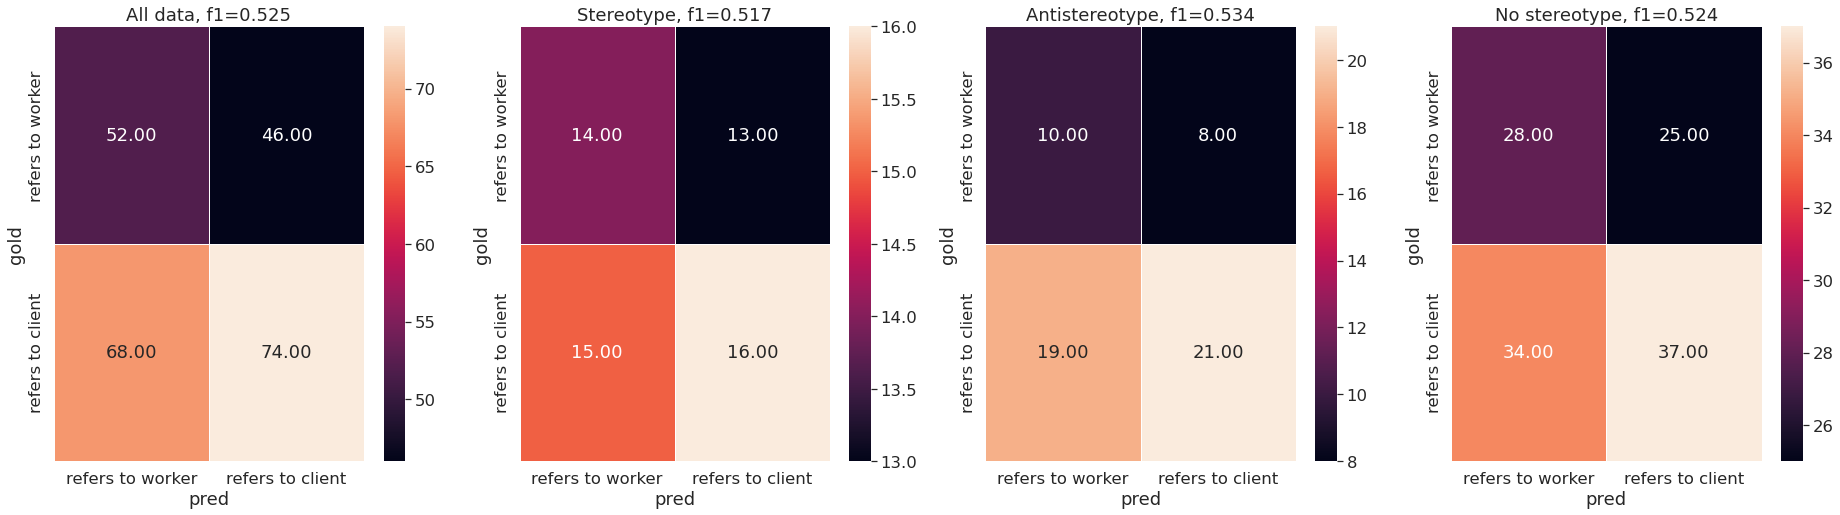

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(32, 8))
labs = ["refers to worker", "refers to client"]
cf_matrix = pd.crosstab(cf_df.gold, cf_df.pred, normalize=normalize)
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax[0], fmt='.2f', xticklabels=labs, yticklabels=labs)
ax[0].set_title(f"All data, f1={round(f1_score(cf_df.gold, cf_df.pred, average='micro'), 3)}")

partial = cf_df[cf_df.stereotype == 1]
cf_matrix = pd.crosstab(partial.gold, partial.pred, normalize=normalize)
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax[1], fmt='.2f', xticklabels=labs, yticklabels=labs)
ax[1].set_title(f"Stereotype, f1={round(f1_score(partial.gold, partial.pred, average='micro'), 3)}")

partial = cf_df[cf_df.stereotype == -1]
cf_matrix = pd.crosstab(partial.gold, partial.pred, normalize=normalize)
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax[2], fmt='.2f', xticklabels=labs, yticklabels=labs)
ax[2].set_title(f"Antistereotype, f1={round(f1_score(partial.gold, partial.pred, average='micro'), 3)}")

partial = cf_df[cf_df.stereotype == 0]
cf_matrix = pd.crosstab(partial.gold, partial.pred, normalize=normalize)
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax[3], fmt='.2f', xticklabels=labs, yticklabels=labs)
ax[3].set_title(f"No stereotype, f1={round(f1_score(partial.gold, partial.pred, average='micro'), 3)}")
plt.show()